<a href="https://colab.research.google.com/github/hamednasr/missing-data-with-pytorch/blob/main/finding_missing_data_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from IPython import display
display.set_matplotlib_formats('svg')

In [194]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [196]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


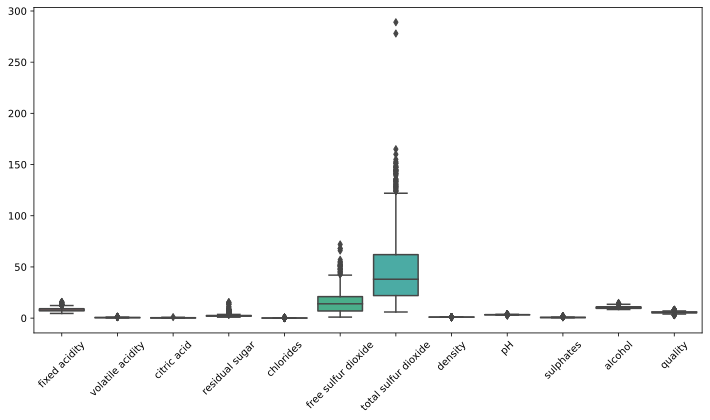

In [197]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data)
plt.xticks(rotation=45);

In [198]:
data[data['total sulfur dioxide']>200]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


In [199]:
data[data['total sulfur dioxide']>200].index

Int64Index([1079, 1081], dtype='int64')

In [200]:
data.drop(labels = data[data['total sulfur dioxide']>200].index,axis=0,inplace=True)

In [201]:
data[data['total sulfur dioxide']>200]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


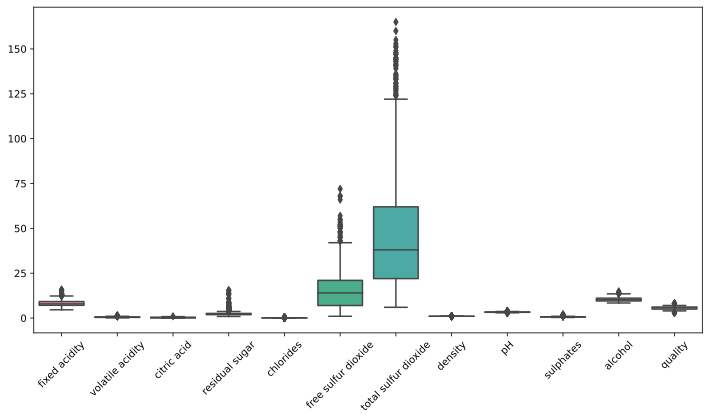

In [202]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data)
plt.xticks(rotation=45);

### normalize data and train test sets:

In [203]:
data = pd.DataFrame(stats.zscore(data,axis=0),columns=data.columns)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,-0.786623
1593,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,0.453492
1594,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,0.453492
1595,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,-0.786623


In [204]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03
mean,-2.139804e-16,9.065315e-17,5.403039e-16,-4.115542e-17,-3.595190e-16,-1.897355e-16,-1.803504e-16,3.403345e-14,3.047726e-16,2.351805e-16,-7.387120e-16,7.301958e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,-3.266852e+00
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,-7.866225e-01
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,4.534922e-01
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,4.534922e-01
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,2.933721e+00


In [205]:
testIndex=np.random.choice(range(1599),size = 10,replace=False)

In [206]:
trainIndex=list(set(data.index)-set(testIndex))

In [241]:
list(range(3))+list(range(4,12))

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

In [211]:
data.drop([trainIndex,:3])

,fixed acidity,volatile acidity,citric acid
0,-0.528350,0.960657,-1.391823
1,-0.298673,1.966614,-1.391823
2,-0.298673,1.295976,-1.185980
3,1.653579,-1.386577,1.489975
4,-0.528350,0.960657,-1.391823
...,...,...,...
1592,-1.217380,0.401792,-0.980138
1593,-1.389638,0.122359,-0.877216
1594,-1.159961,-0.101187,-0.722834
1595,-1.389638,0.653281,-0.774295


In [242]:
train_data = data.iloc[trainIndex,list(range(3))+list(range(4,12))]
train_label = data.iloc[trainIndex,3]
test_data = data.iloc[testIndex,list(range(3))+list(range(4,12))]
test_label = data.iloc[testIndex,3]